In [118]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn

from scipy.interpolate import griddata
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam, LBFGS
from torch.optim.lr_scheduler import SequentialLR, LinearLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from actnet.ActNet import ActNet
from actnet.utils import adaptive_gradient_clipping, pinns_loss

## SOTA Comparisons

### 2D Poisson PDE

In [42]:
BATCH_SIZE = 5000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_EPOCHS_TRAIN = 30000
N_EPOCHS_FINE_TUNE = 100
W = 32

In [ ]:
data = pd.read_csv(f"data/poisson/poisson_w{W}.csv")

x = torch.Tensor(data["x"])
y = torch.Tensor(data["y"])
u_exact = torch.Tensor(data["u"])

X_star = torch.hstack((x.flatten().reshape(-1, 1), y.flatten().reshape(-1, 1)))

boundary = torch.where(
                (X_star[:, 0] == -1) | (X_star[:, 0] == 1) | (X_star[:, 1] == -1) | (X_star[:, 1] == 1)
            )[0]

x_train = X_star[boundary]
u_train = u_exact[boundary]

indices = [i for i in range(len(X_star)) if i not in boundary]
x_train_f = X_star[indices]

poisson_data = DataLoader(TensorDataset(x_train, x_train_f, u_train), batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
d_in = 2
d_out = 1
d = 128
m = 128
N = 8
L = 2

model_poisson = ActNet(d_in, d_out, d, m, N, L).to(DEVICE)

optimizer = Adam(model_poisson.parameters(), lr=1e-7)
scheduler = SequentialLR(optimizer, [LinearLR(optimizer, 1e-7, 5e-3, 1000), StepLR(optimizer, 1000, 0.75)], [1000])

In [46]:
writer = SummaryWriter()
for epoch in tqdm(range(N_EPOCHS_TRAIN)):
    model_poisson.train()
    total_loss = 0
    for inputs, inputs_f, targets in poisson_data:
        inputs, inputs_f, targets = inputs.to(DEVICE), inputs_f.to(DEVICE), targets.to(DEVICE)

        inputs_f.requires_grad = True

        u_pred = model_poisson(inputs).squeeze()
        outputs_f = model_poisson(inputs_f).squeeze()

        u_pred = u_pred * (1 - inputs[:, 0]**2) * (1 - inputs[:, 1]**2)
        outputs_f = outputs_f * (1 - inputs_f[:, 0]**2) * (1 - inputs_f[:, 1]**2)

        u_grad = torch.autograd.grad(outputs_f, inputs_f, grad_outputs=torch.ones_like(outputs_f), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_grad[:, 0], inputs_f, grad_outputs=torch.ones_like(u_grad[:, 0]), create_graph=True)[0][:, 0]
        u_yy = torch.autograd.grad(u_grad[:, 1], inputs_f, grad_outputs=torch.ones_like(u_grad[:, 1]), create_graph=True)[0][:, 1]
        
        f_pred = u_xx + u_yy - 2 * np.pi**2 * W**2 * torch.sin(np.pi * W * inputs_f[:, 0]) * torch.sin(np.pi * W * inputs_f[:, 1])

        loss = pinns_loss(u_pred, targets, f_pred)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        adaptive_gradient_clipping(model_poisson.parameters())
        optimizer.step()
    scheduler.step()
    writer.add_scalar("Loss/Adam/Poisson", total_loss / len(poisson_data), epoch)
writer.close()

  3%|▎         | 996/30000 [00:19<10:05, 47.93it/s]/home/ethan/.virtualenvs/deepdac/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 30000/30000 [09:43<00:00, 51.39it/s]


In [47]:
def loss_closure():
    optimizer.zero_grad()

    inputs, inputs_f, targets = x_train.to(DEVICE), x_train_f.to(DEVICE), u_train.to(DEVICE)

    inputs_f.requires_grad = True

    u_pred = model_poisson(inputs).squeeze()
    outputs_f = model_poisson(inputs_f).squeeze()

    u_pred = u_pred * (1 - inputs[:, 0]**2) * (1 - inputs[:, 1]**2)
    outputs_f = outputs_f * (1 - inputs_f[:, 0]**2) * (1 - inputs_f[:, 1]**2)

    u_xy = torch.autograd.grad(outputs_f, inputs_f, grad_outputs=torch.ones_like(outputs_f), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_xy[:, 0], inputs_f, grad_outputs=torch.ones_like(u_xy[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_xy[:, 1], inputs_f, grad_outputs=torch.ones_like(u_xy[:, 1]), create_graph=True)[0][:, 1]
    
    f_pred = u_xx + u_yy - 2 * np.pi**2 * W**2 * torch.sin(np.pi * W * inputs_f[:, 0]) * torch.sin(np.pi * W * inputs_f[:, 1])

    loss = pinns_loss(u_pred, targets, f_pred)
    writer.add_scalar("Loss/LBFGS/Poisson", loss.item(), epoch)

    loss.backward()
    return loss

optimizer = LBFGS(model_poisson.parameters(), lr=1e-3, max_iter=100)

model_poisson.train()
for epoch in tqdm(range(N_EPOCHS_FINE_TUNE)):
    optimizer.step(loss_closure)

100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


In [50]:
X, Y = torch.meshgrid(x, y)

u_pred = model_poisson(X_star.to(DEVICE)).detach().cpu()
U_pred = griddata(X_star, u_pred, (X, Y), method="cubic")

fig = plt.figure()
ax = fig.add_subplot(111)

ax.contourf(X, Y, U_pred, levels=50, cmap="viridis")

ax.set_xlabel("$x$", size=20)
ax.set_ylabel("$y$", size=20)
ax.set_title("Prediction", fontsize=20) 

fig.colorbar()
plt.show()

MemoryError: Unable to allocate 64.0 GiB for an array with shape (65536, 65536, 2) and data type float64

In [ ]:
u_pred = model_poisson(torch.cat([x, y], dim=1)).detach().cpu()
U_pred = griddata(X_star, u_pred, (X, Y), method="cubic")

fig = plt.figure()
ax = fig.add_subplot(111)

ax.contourf(X, Y, u_exact, levels=50, cmap="viridis")

ax.set_xlabel("$x$", size=20)
ax.set_ylabel("$y$", size=20)
ax.set_title("Prediction", fontsize=20) 

fig.colorbar()
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.contourf(X, Y, (U_pred - u_exact).abs(), levels=50, cmap="viridis")

ax.set_xlabel("$x$", size=20)
ax.set_ylabel("$y$", size=20)
ax.set_title("Prediction", fontsize=20) 

fig.colorbar()
plt.show()

In [52]:
print("L2 error: ", ((u_pred - u_exact)**2).mean())

: 

### Allen-Cahn PDE

In [2]:
BATCH_SIZE = 10000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_EPOCHS_TRAIN = 100000
N_EPOCHS_FINE_TUNE = 100
W = 32

In [ ]:
data = scipy.io.loadmat("data/allen_cahn.mat")
usol = torch.Tensor(data["uu"].flatten().reshape(-1, 1))

t_star = torch.Tensor(data["tt"][0])
x_star = torch.Tensor(data["x"][0])
TT, XX = torch.meshgrid(t_star, x_star)

X_star = torch.hstack((XX.flatten().reshape(-1, 1), TT.flatten().reshape(-1, 1)))

boundary = torch.where(
                (X_star[:, 0] == -1) | (X_star[:, 0] == 1) | (X_star[:, 1] == 0) | (X_star[:, 1] == 1)
            )[0]

x_train = X_star[boundary]
u_train = usol[boundary]

indices = [i for i in range(len(X_star)) if i not in boundary]
x_train_f = X_star[indices]

allen_cahn_data = DataLoader(TensorDataset(x_train, x_train_f, u_train), batch_size=BATCH_SIZE, shuffle=True)

/home/ethan/.virtualenvs/deepdac/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
d_in = 2
d_out = 1
d = 128
m = 128
N = 8
L = 2

model_allen_cahn = ActNet(d_in, d_out, d, m, N, L).to(DEVICE)

optimizer = Adam(model_allen_cahn.parameters(), lr=1e-7)
scheduler = SequentialLR(optimizer, [LinearLR(optimizer, 1e-7, 5e-3, 1000), StepLR(optimizer, 1000, 0.9)], [1000])

In [ ]:
writer = SummaryWriter()
for epoch in tqdm(range(N_EPOCHS_TRAIN)):
    model_allen_cahn.train()
    total_loss = 0
    for inputs, inputs_f, targets in allen_cahn_data:
        inputs, inputs_f, targets = inputs.to(DEVICE), inputs_f.to(DEVICE), targets.to(DEVICE)

        inputs_f.requires_grad = True

        u_pred = model_allen_cahn(inputs).squeeze()
        outputs_f = model_allen_cahn(inputs_f).squeeze()

        u_pred = (1 - inputs[:, 1]) * (inputs[:, 1]**2 * torch.cos(np.pi * inputs[:, 0])) + inputs[:, 1] * ((1 - inputs[:, 0]**2) * u_pred - 1)
        outputs_f = (1 - inputs_f[:, 1]) * (inputs_f[:, 1]**2 * torch.cos(np.pi * inputs_f[:, 0])) + inputs_f[:, 1] * ((1 - inputs_f[:, 0]**2) * outputs_f - 1)

        u_xt = torch.autograd.grad(outputs_f, inputs_f, grad_outputs=torch.ones_like(outputs_f), create_graph=True)[0]
        u_t = u_xt[:, 1]
        u_xx = torch.autograd.grad(u_xt[:, 0], inputs_f, grad_outputs=torch.ones_like(u_xt[:, 0]), create_graph=True)[0][:, 0]
        
        f_pred = u_t - 0.0001 * u_xx + 5 * (outputs_f**3 - outputs_f)

        loss = pinns_loss(u_pred, targets, f_pred)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        adaptive_gradient_clipping(model_allen_cahn.parameters())
        optimizer.step()
    scheduler.step()
    writer.add_scalar("Loss/Adam/Allen-Cahn", total_loss / len(allen_cahn_data), epoch)
writer.close()

  1%|          | 997/100000 [00:20<29:25, 56.08it/s] /home/ethan/.virtualenvs/deepdac/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 100000/100000 [33:40<00:00, 49.49it/s]


In [ ]:
def loss_closure():
    optimizer.zero_grad()

    inputs, inputs_f, targets = x_train.to(DEVICE), x_train_f.to(DEVICE), u_train.to(DEVICE)

    inputs_f.requires_grad = True

    u_pred = model_allen_cahn(inputs).squeeze()
    outputs_f = model_allen_cahn(inputs_f).squeeze()

    u_pred = (1 - inputs[:, 1]) * (inputs[:, 1]**2 * torch.cos(np.pi * inputs[:, 0])) + inputs[:, 1] * ((1 - inputs[:, 0]**2) * u_pred - 1)
    outputs_f = (1 - inputs_f[:, 1]) * (inputs_f[:, 1]**2 * torch.cos(np.pi * inputs_f[:, 0])) + inputs_f[:, 1] * ((1 - inputs_f[:, 0]**2) * outputs_f - 1)

    u_xt = torch.autograd.grad(outputs_f, inputs_f, grad_outputs=torch.ones_like(outputs_f), create_graph=True)[0]
    u_t = u_xt[:, 1]
    u_xx = torch.autograd.grad(u_xt[:, 0], inputs_f, grad_outputs=torch.ones_like(u_xt[:, 0]), create_graph=True)[0][:, 0]
    
    f_pred = u_t - 0.0001 * u_xx + 5 * (outputs_f**3 - outputs_f)

    loss = pinns_loss(u_pred, targets, f_pred)
    writer.add_scalar("Loss/LBFGS/Allen-Cahn", loss.item(), epoch)

    loss.backward()
    return loss

optimizer = LBFGS(model_allen_cahn.parameters(), lr=1e-3, max_iter=100)

model_allen_cahn.train()
for epoch in tqdm(range(N_EPOCHS_FINE_TUNE)):
    optimizer.step(loss_closure)

100%|██████████| 100/100 [20:32<00:00, 12.33s/it]


In [ ]:
u_pred = model_allen_cahn(torch.cat([x_star, t_star], dim=1)).detach().cpu()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.pcolor(TT, XX, u_pred, cmap="jet")

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.set_title("Prediction", fontsize=20) 

fig.colorbar()

plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.pcolor(TT, XX, usol, cmap="jet")

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.set_title("Reference Solution", fontsize=20) 

fig.colorbar()

plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.pcolor(TT, XX, (usol - u_pred).abs(), cmap="jet")

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.set_title("Absolute Error", fontsize=20) 

fig.colorbar()

plt.show()

In [ ]:
print("L2 Error: ", torch.mean((usol - u_pred)**2))

### Burgers

In [2]:
BATCH_SIZE = 1000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_EPOCHS_TRAIN = 10000
N_EPOCHS_FINE_TUNE = 100
W = 32

In [6]:
data = scipy.io.loadmat("./data/burgers_shock.mat")

t = torch.Tensor(data["t"].flatten())
x = torch.Tensor(data["x"].flatten())
Exact = torch.Tensor(data["usol"]).T

T, X = torch.meshgrid(t, x)
X_star = torch.hstack((X.flatten().reshape(-1, 1), T.flatten().reshape(-1, 1)))
u_star = Exact.flatten()


N_u = 100
boundary = torch.where(
                (X_star[:, 1] == 0) | (X_star[:, 0] == x.min()) | (X_star[:, 0] == x.max())
            )[0]
indices = np.random.choice(boundary, N_u, replace=False)
x_train = X_star[indices, 0].reshape(-1, 1)
t_train = X_star[indices, 1].reshape(-1, 1)
u_train = u_star[indices].reshape(-1, 1)


N_f = 10000
indices = np.random.choice(X_star.shape[0], N_f, replace=False)
x_train_f = X_star[indices, 0].reshape(-1, 1)
t_train_f = X_star[indices, 1].reshape(-1, 1)


x_train_f = torch.vstack((x_train_f, x_train))
t_train_f = torch.vstack((t_train_f, t_train))


def prepare(*tensors):
    return (torch.Tensor(t).float().to(DEVICE) for t in tensors)

x_train, t_train, u_train = prepare(x_train, t_train, u_train)
x_train_f, t_train_f = prepare(x_train_f, t_train_f)

x_star, t_star = prepare(*X_star.split((1, 1), dim=1))

In [ ]:
d_in = 2
d_out = 1
d = 128
m = 128
N = 8
L = 2

model_burgers = ActNet(d_in, d_out, d, m, N, L).to(DEVICE)

In [19]:
def loss_closure():
    optimizer.zero_grad()

    inputs_x, inputs_t, inputs_f_x, inputs_f_t, targets = x_train.to(DEVICE), t_train.to(DEVICE), x_train_f.to(DEVICE), t_train_f.to(DEVICE), u_train.to(DEVICE)

    inputs_f_x.requires_grad = True
    inputs_f_t.requires_grad = True

    u_pred = model_burgers(torch.cat([inputs_x, inputs_t], dim=1)).squeeze()
    outputs_f = model_burgers(torch.cat([inputs_f_x, inputs_f_t], dim=1)).squeeze()

    df_dt = torch.autograd.grad(outputs_f, inputs_f_t, grad_outputs=torch.ones_like(outputs_f), create_graph=True)[0]
    df_dx = torch.autograd.grad(outputs_f, inputs_f_x, grad_outputs=torch.ones_like(outputs_f), create_graph=True)[0]
    df_dx2 = torch.autograd.grad(df_dx, inputs_f_x, grad_outputs=torch.ones_like(df_dx), create_graph=True)[0]
    
    f_pred = df_dt + outputs_f * df_dx - (0.01 / np.pi) * df_dx2

    loss = pinns_loss(u_pred, targets, f_pred)
    writer.add_scalar("Loss/LBFGS/Burgers", loss.item(), epoch)

    loss.backward()
    return loss

optimizer = LBFGS(model_burgers.parameters(), lr=1e-3, max_iter=100)

writer = SummaryWriter()
model_burgers.train()
for epoch in tqdm(range(N_EPOCHS_FINE_TUNE)):
    optimizer.step(loss_closure)
writer.close()

100%|██████████| 100/100 [07:50<00:00,  4.70s/it]


/tmp/ipykernel_1597/1925256981.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


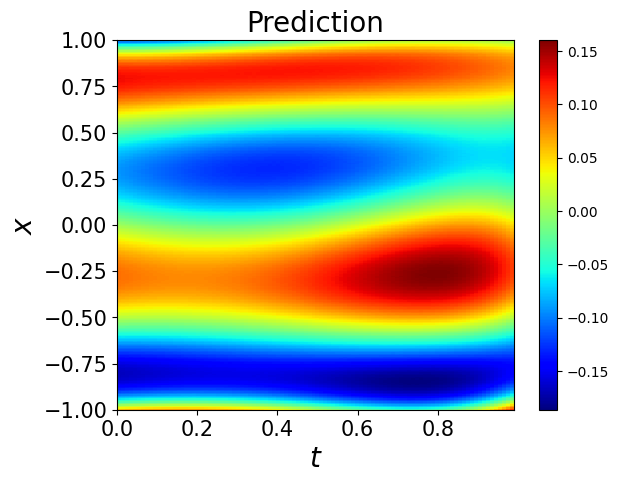

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)

u_pred = model_burgers(torch.cat([x_star, t_star], dim=1)).detach().cpu()

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")

h = ax.imshow(
    U_pred.T,
    interpolation="nearest",
    cmap="jet",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={"size": 15},
)
ax.set_title("Prediction", fontsize=20)  # font size doubled
ax.tick_params(labelsize=15)
cbar = fig.colorbar(h)

plt.show()

/tmp/ipykernel_1597/4245291332.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


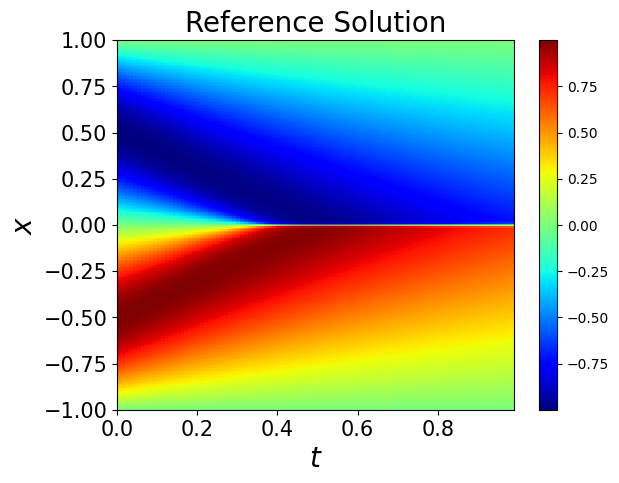

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)

h = ax.imshow(
    Exact.T,
    interpolation="nearest",
    cmap="jet",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={"size": 15},
)
ax.set_title("Reference Solution", fontsize=20)  # font size doubled
ax.tick_params(labelsize=15)
cbar = fig.colorbar(h)

plt.show()

/tmp/ipykernel_1597/2379221454.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


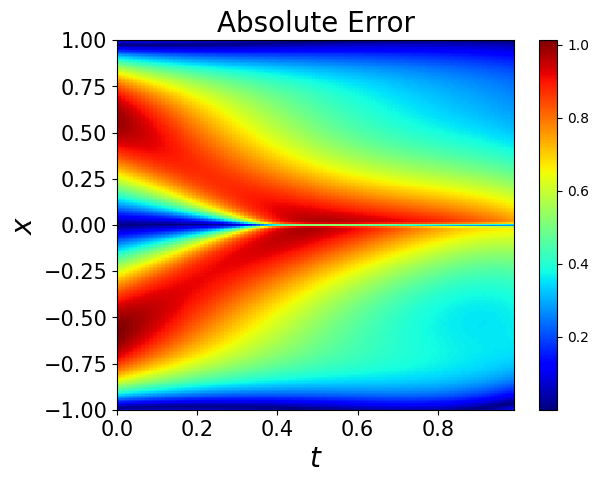

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)

h = ax.imshow(
    np.abs((U_pred.T - Exact.T.numpy())),
    interpolation="nearest",
    cmap="jet",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={"size": 15},
)
ax.set_title("Absolute Error", fontsize=20)  # font size doubled
ax.tick_params(labelsize=15)
cbar = fig.colorbar(h)

plt.show()

In [ ]:
print("L2 Error: ", np.mean((U_pred.T - Exact.T.numpy()).flatten()**2))

## Influence of the Hyperparameters

## Loss Function

### Influence of the different terms

### Simple problem without physics information

In [167]:
train_losses = {
    "Perceptron": [],
    "MLP": [],
    "ActNet": []
}

test_losses = {
    "Perceptron": [],
    "MLP": [],
    "ActNet": []
}

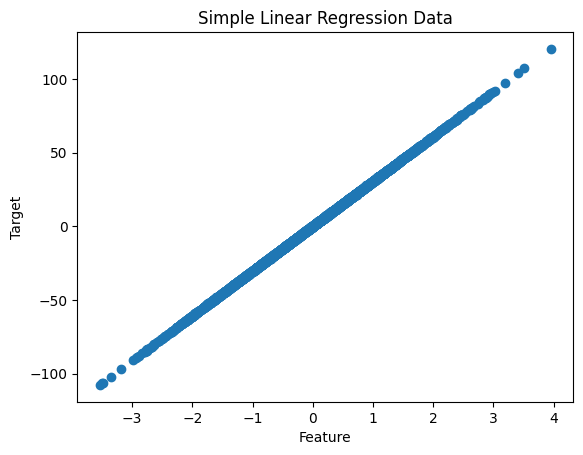

In [168]:
X, y = make_regression(n_samples=5000, n_features=1, noise=0.2)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_reg_lin_data = DataLoader(TensorDataset(X_train, y_train), batch_size=300, shuffle=True)
test_reg_lin_data = DataLoader(TensorDataset(X_test, y_test), batch_size=300, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.scatter(X, y)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title("Simple Linear Regression Data")
plt.show()

#### Perceptron

In [169]:
perceptron = nn.Linear(1, 1).to(device)

optimizer = Adam(perceptron.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [170]:
for epoch in tqdm(range(250)):
    total_loss = 0
    for inputs, targets in train_reg_lin_data:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = perceptron(inputs)

        loss = criterion(outputs, targets)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses["Perceptron"].append(total_loss / len(train_reg_lin_data))

    with torch.no_grad():
        total_loss = 0
        for inputs, targets in test_reg_lin_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = perceptron(inputs)

            loss = criterion(outputs, targets)
            total_loss += loss.item()
        test_losses["Perceptron"].append(total_loss / len(test_reg_lin_data))

100%|██████████| 250/250 [00:10<00:00, 24.91it/s]


#### MLP

In [171]:
mlp = nn.Sequential(
    nn.Linear(1, 8),
    nn.Tanh(),
    nn.Linear(8, 8),
    nn.Tanh(),
    nn.Linear(8, 1)
).to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [172]:
for epoch in tqdm(range(250)):
    total_loss = 0
    for inputs, targets in train_reg_lin_data:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = mlp(inputs)

        loss = criterion(outputs, targets)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses["MLP"].append(total_loss / len(train_reg_lin_data))

    with torch.no_grad():
        total_loss = 0
        for inputs, targets in test_reg_lin_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = mlp(inputs)

            loss = criterion(outputs, targets)
            total_loss += loss.item()
        test_losses["MLP"].append(total_loss / len(test_reg_lin_data))

100%|██████████| 250/250 [00:10<00:00, 23.12it/s]


## ActNet

In [173]:
d_in = 1
d_out = 1
d = 128
m = 128
N = 8
L = 2

actnet = ActNet(d_in, d_out, d, m, N, L).to(device)
optimizer = Adam(actnet.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [174]:
actnet.train()
for epoch in tqdm(range(250)):
    total_loss = 0
    for inputs, targets in train_reg_lin_data:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = actnet(inputs)

        loss = criterion(outputs, targets)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        adaptive_gradient_clipping(actnet.parameters(), clip_factor=1e-5)
        optimizer.step()
    train_losses["ActNet"].append(total_loss / len(train_reg_lin_data))

    with torch.no_grad():
        total_loss = 0
        for inputs, targets in test_reg_lin_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = actnet(inputs)

            loss = criterion(outputs, targets)
            total_loss += loss.item()
        test_losses["ActNet"].append(total_loss / len(test_reg_lin_data))

100%|██████████| 250/250 [00:29<00:00,  8.34it/s]


#### Loss Functions

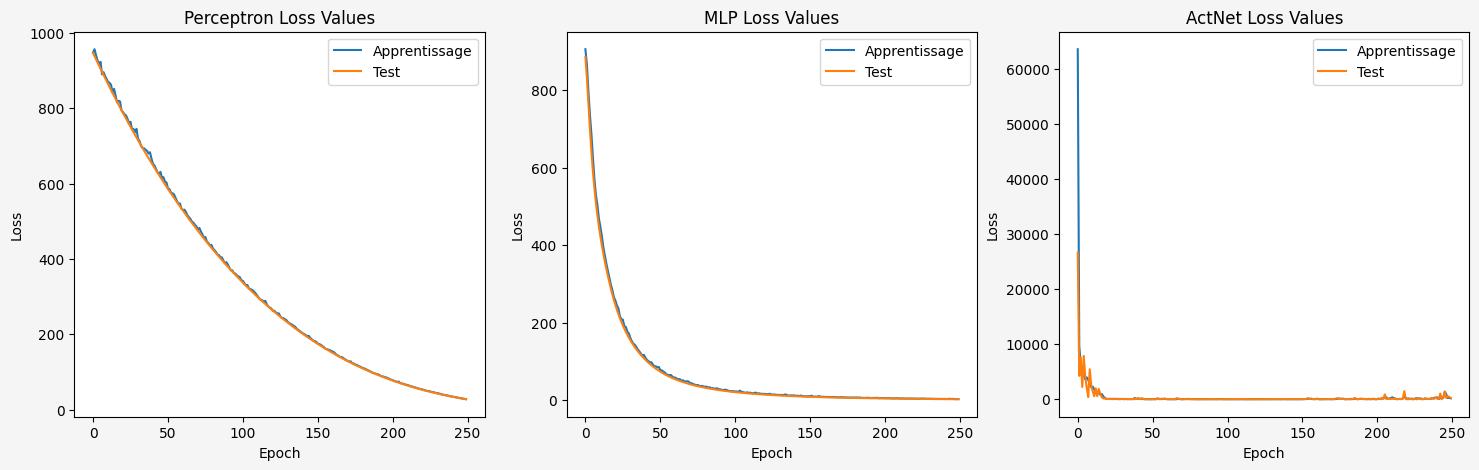

In [191]:
model_names = list(train_losses.keys())
n_models = len(model_names)

plt.subplots(1, n_models, figsize=(6*n_models, 5), facecolor="#f5f5f5")
for i, model_name in enumerate(model_names):
    plt.subplot(1, n_models, i+1)
    plt.plot(train_losses[model_name], label="Apprentissage")
    plt.plot(test_losses[model_name], label="Test")
    plt.title(f"{model_name} Loss Values")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
plt.show()

In [181]:
for model_name in model_names:
    print(f"{model_name} Loss - Train: {train_losses[model_name][-1]} - Test: {test_losses[model_name][-1]}")

Perceptron Loss - Train: 28.094139644077845 - Test: 27.88532066345215
MLP Loss - Train: 2.8413124393139566 - Test: 2.4936362467706203
ActNet Loss - Train: 163.41509710039412 - Test: 210.7166748046875
